# NEMO MMB CTDO Profile data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
%matplotlib inline

import re
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import pandas as pd

## 1. Retrieve and parse list of all base subdirectories (deployments?)

**This web server has restricted access; it's only accessible from the UW APL subdomain.**

In [85]:
# base_url = "http://waves.apl.uw.edu/~mooring/nemo/NEMO_SUBSURFACE_201805/MMP/CTD/"
base_url = "http://waves.apl.uw.edu/~mooring/nemo/"

In [86]:
r = requests.get(base_url)

In [87]:
base_soup = BeautifulSoup(r.content, "lxml")

In [89]:
# Could've stripped "/" for clarity. d.text.strip('/')
dir_lst = [d.text for d in base_soup.find_all(href=re.compile(r'NEMO[\w]+'))]

In [90]:
dir_lst

['NEMO_SUBSURFACE_201705/',
 'NEMO_SUBSURFACE_201707/',
 'NEMO_SUBSURFACE_201709/',
 'NEMO_SUBSURFACE_201805/']

## 2. Retrieve data files from each subdirectory

In [99]:
csv_url_lst = []
for dir_name in dir_lst:
    dir_url = f'{base_url}{dir_name}MMP/CTD/'
    dir_r = requests.get(dir_url)
    print(dir_r.url)
    dir_soup = BeautifulSoup(dir_r.content, "lxml")
    
    csv_url_lst += [dir_url+fn.text for fn in dir_soup.find_all(href=re.compile(r'c[\d]+\.csv'))]

http://waves.apl.uw.edu/~mooring/nemo/NEMO_SUBSURFACE_201705/MMP/CTD/
http://waves.apl.uw.edu/~mooring/nemo/NEMO_SUBSURFACE_201707/MMP/CTD/
http://waves.apl.uw.edu/~mooring/nemo/NEMO_SUBSURFACE_201709/MMP/CTD/
http://waves.apl.uw.edu/~mooring/nemo/NEMO_SUBSURFACE_201805/MMP/CTD/


In [101]:
# re.compile('data' + r'(.{12})\.json')
# csv_lst = [d.text for d in soup.find_all(href=re.compile(r'c[\d]+\.csv'))]

In [102]:
len(csv_url_lst), csv_url_lst[-4:]

(2296,
 ['http://waves.apl.uw.edu/~mooring/nemo/NEMO_SUBSURFACE_201805/MMP/CTD/c0001194.csv',
  'http://waves.apl.uw.edu/~mooring/nemo/NEMO_SUBSURFACE_201805/MMP/CTD/c0001206.csv',
  'http://waves.apl.uw.edu/~mooring/nemo/NEMO_SUBSURFACE_201805/MMP/CTD/c0001218.csv',
  'http://waves.apl.uw.edu/~mooring/nemo/NEMO_SUBSURFACE_201805/MMP/CTD/c0001219.csv'])

### Retrieve each data file as a data frame while appending into a list of data frames. 
Then concatenate into single data frame.

In [ ]:
dfs = []
for csv_url in csv_url_lst:
    try:
        dfs.append(pd.read_csv(csv_url))
    except:
        continue

df = pd.concat(dfs)

In [104]:
df.head()

,time,conductivity,temperature,pressure,oxygen
0,1.493762e+09,34.3243,10.8782,2.03,4340
1,1.493762e+09,34.3244,10.8782,2.30,4330
2,1.493762e+09,34.3238,10.8767,2.09,4323
3,1.493762e+09,34.3255,10.8795,1.91,4321
4,1.493762e+09,34.3224,10.8747,2.26,4320


In [105]:
df.tail()

,time,conductivity,temperature,pressure,oxygen
478,1.533701e+09,34.8540,8.9001,21.47,3301
479,1.533701e+09,34.8533,8.8997,21.47,3301
480,1.533701e+09,34.8527,8.8990,21.48,3301
481,1.533701e+09,34.8536,8.9000,21.48,3301
482,1.533701e+09,34.8538,8.8995,21.49,3300


- Now need to convert "time" (epoch secs) to a datetime
- Also note that three's no salinity; so will have to use the seawater package to convert from conductivity, temp, pressure

In [107]:
df['datetime'] = pd.to_datetime(df['time'], unit='s')

In [108]:
df.set_index('datetime', inplace=True)

In [109]:
df.tail()

,time,conductivity,temperature,pressure,oxygen
datetime,,,,,
2018-08-08 04:06:11.855000019,1.533701e+09,34.8540,8.9001,21.47,3301
2018-08-08 04:06:12.883999825,1.533701e+09,34.8533,8.8997,21.47,3301
2018-08-08 04:06:13.912999868,1.533701e+09,34.8527,8.8990,21.48,3301
2018-08-08 04:06:14.942000151,1.533701e+09,34.8536,8.9000,21.48,3301
2018-08-08 04:06:15.970999956,1.533701e+09,34.8538,8.8995,21.49,3300


In [110]:
df.dtypes

time            float64
conductivity    float64
temperature     float64
pressure        float64
oxygen            int64
dtype: object

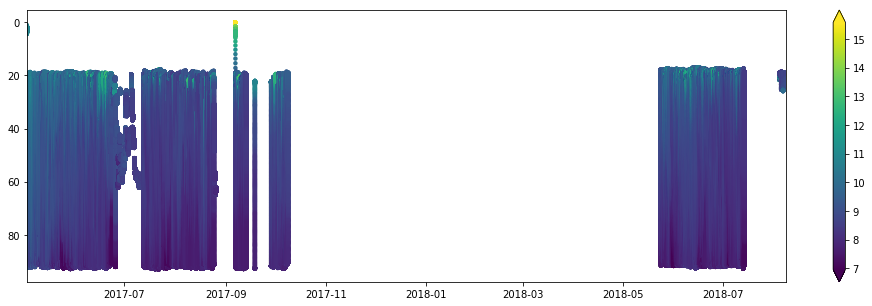

In [111]:
fig, ax = plt.subplots(figsize=(17, 5))
kw = dict(s=20, c=df['temperature'], marker='o', edgecolor='none')
#cs = ax.scatter(df['datetime'], df['pressure'], **kw)
cs = ax.scatter(df.index, df['pressure'], **kw)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])

cbar = fig.colorbar(cs, orientation='vertical', extend='both')

**Save the data frame to a file, so I don't have to re-harvest and reprocess next time.**

In [113]:
pwd

'/home/mayorga/Desktop/OceanHackWeek2018/project'

In [114]:
df.to_pickle('./nemo_mmb_ctd.pkl')